MNIST 기본 과제

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)


batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)


testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


50000
torch.Size([3, 32, 32]) 6


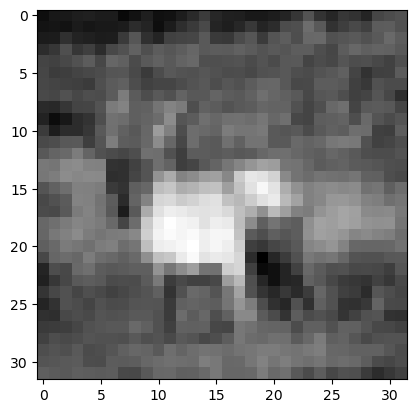

In [2]:
from matplotlib import pyplot as plt


print(len(trainset)) #이미지 데이터 총 5만개
print(trainset[0][0].shape, trainset[0][1])
#데이터 5만개중 첫번째 이미지 배열의 크기
#데이터 5만개중 첫번째는 어떤 수로 label 되어있는지
plt.imshow(trainset[3][0][0], cmap='grey')
#세번째 [0]이 사진과 match 되어있는지? 

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter) #dataiter에서 하나 뽑아옴
print(images.shape, labels.shape) 
#image 배열의 데이터 설명임
#32x32 이미지 데이터를 256개의 batch size로 설정함
#labels의 경우 이미지 데이터의 label이므로 1x256의 크기

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [4]:
from torch import nn

class LeakyRELU(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) #0~9의 확률이 나오기때문

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x
      
class Sigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) #0~9의 확률이 나오기때문

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [5]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=1)
      
    # torch.max에서 두 번째 인자는 dim을 의미
    # 1로 지정했다는 것은 하나의 행에서 가장 큰 값을 찾겠다는 것
      
    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc*100 / cnt

In [6]:
def train_and_test(model, train_loss, test_loss, train_accuracy, test_accuracy, optimizer):
    n_epochs = 50
    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        cost = 0.
        cnt = 0
        acc = 0
        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            cost += loss.item() #1epoch의 총 Loss Batch size 만큼 더함
            cnt += labels.shape[0]

            preds = torch.argmax(outputs, dim=1)
            acc += (labels == preds).sum().item()
        train_accuracy.append(acc/cnt)
        train_loss.append(cost/len(trainloader)) # epoch 별 평균 손실 저장
        print("epoch : {} | loss : {:.6f}" .format(epoch, cost/len(trainloader)))
        
        with torch.no_grad():# 미분하지 않겠다
            model.eval()
            cnt = 0
            acc = 0
            cost = 0
        
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
                outputs = model(inputs)    
        
                loss = criterion(outputs, labels)
                cost += loss.item()
                cnt += labels.shape[0]

                preds = torch.argmax(outputs, dim=1)
                acc += (labels == preds).sum().item() #labels 와 preds는 True or false 로 반환됨
                # sum은 0또는 1을 다 합해서 총 맞춘 수를 확인할수있음
            test_accuracy.append(acc/cnt)
            test_loss.append(cost/len(testloader))

In [7]:
def plot(train_loss, test_loss, test_accuracy, train_accuracy):
    plt.subplot(2,1,1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label ='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    plt.subplot(2,1,2)
    plt.plot(test_accuracy, label='test accuracy')
    plt.plot(train_accuracy, label ='train accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy [%]')
    plt.title('Accuracy')         
    plt.legend()
    plt.show()

epoch : 0 | loss : 2.308040
epoch : 1 | loss : 2.304653
epoch : 2 | loss : 2.302560
epoch : 3 | loss : 2.300737
epoch : 4 | loss : 2.299116
epoch : 5 | loss : 2.297562
epoch : 6 | loss : 2.296040
epoch : 7 | loss : 2.294313
epoch : 8 | loss : 2.292502
epoch : 9 | loss : 2.290759
epoch : 10 | loss : 2.289176
epoch : 11 | loss : 2.287430
epoch : 12 | loss : 2.285763
epoch : 13 | loss : 2.284231
epoch : 14 | loss : 2.282525
epoch : 15 | loss : 2.281043
epoch : 16 | loss : 2.279220
epoch : 17 | loss : 2.277622
epoch : 18 | loss : 2.276007
epoch : 19 | loss : 2.274357
epoch : 20 | loss : 2.272662
epoch : 21 | loss : 2.270849
epoch : 22 | loss : 2.269157
epoch : 23 | loss : 2.267622
epoch : 24 | loss : 2.265755
epoch : 25 | loss : 2.263809
epoch : 26 | loss : 2.262148
epoch : 27 | loss : 2.260323
epoch : 28 | loss : 2.258465
epoch : 29 | loss : 2.256738
epoch : 30 | loss : 2.254654
epoch : 31 | loss : 2.252864
epoch : 32 | loss : 2.251092
epoch : 33 | loss : 2.249284
epoch : 34 | loss : 2.24

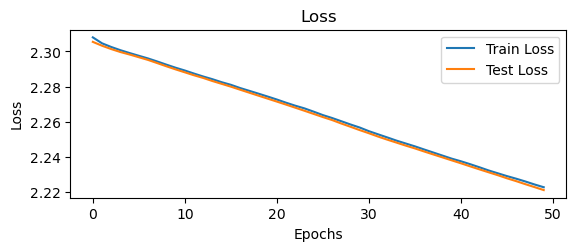

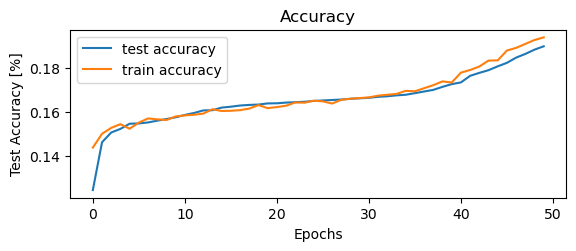

In [9]:
from torch.optim import SGD
from torch.optim import Adam
import torch.nn.functional as f

LeakyRELU_train_loss = []
LeakyRELU_test_loss = []

LeakyRELU_train_accuracy = []
LeakyRELU_test_accuracy = []

lr = 0.001

model_LeakyRELU = LeakyRELU(32 * 32 * 3, 10)
model_LeakyRELU = model_LeakyRELU.to('cuda')

##Model이 Leaky RELU+SGD인 경우
sgd_optimizer = SGD(model_LeakyRELU.parameters(), lr=lr)

train_and_test(model_LeakyRELU, 
               LeakyRELU_train_loss,
               LeakyRELU_test_loss,
               LeakyRELU_train_accuracy,
               LeakyRELU_test_accuracy,
               sgd_optimizer)
plot(LeakyRELU_train_loss,
     LeakyRELU_test_loss, 
     LeakyRELU_train_accuracy, 
     LeakyRELU_test_accuracy)

epoch : 0 | loss : 2.201989
epoch : 1 | loss : 1.956940
epoch : 2 | loss : 1.845333
epoch : 3 | loss : 1.804882
epoch : 4 | loss : 1.780931
epoch : 5 | loss : 1.762446
epoch : 6 | loss : 1.756143
epoch : 7 | loss : 1.738043
epoch : 8 | loss : 1.733800
epoch : 9 | loss : 1.722646
epoch : 10 | loss : 1.712414
epoch : 11 | loss : 1.710526
epoch : 12 | loss : 1.700627
epoch : 13 | loss : 1.693208
epoch : 14 | loss : 1.689057
epoch : 15 | loss : 1.679022
epoch : 16 | loss : 1.678966
epoch : 17 | loss : 1.669147
epoch : 18 | loss : 1.665751
epoch : 19 | loss : 1.661541
epoch : 20 | loss : 1.656135
epoch : 21 | loss : 1.651610
epoch : 22 | loss : 1.647543
epoch : 23 | loss : 1.640245
epoch : 24 | loss : 1.637023
epoch : 25 | loss : 1.638758
epoch : 26 | loss : 1.634504
epoch : 27 | loss : 1.636620
epoch : 28 | loss : 1.632868
epoch : 29 | loss : 1.633143
epoch : 30 | loss : 1.623606
epoch : 31 | loss : 1.626110
epoch : 32 | loss : 1.625952
epoch : 33 | loss : 1.618616
epoch : 34 | loss : 1.61

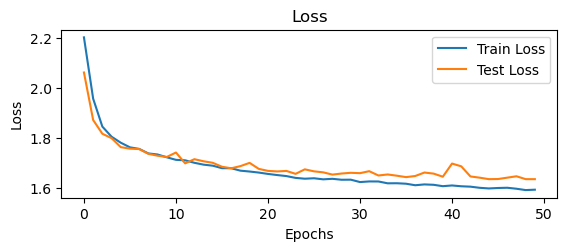

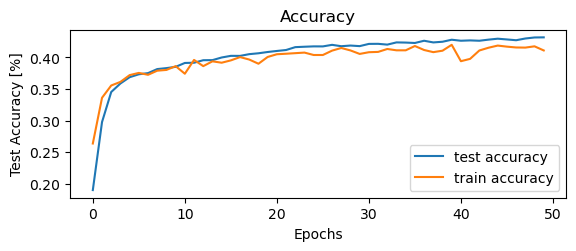

In [10]:
LeakyRELU_train_loss = []
LeakyRELU_test_loss = []

LeakyRELU_train_accuracy = []
LeakyRELU_test_accuracy = []

model_LeakyRELU = LeakyRELU(32 * 32 * 3, 10)
model_LeakyRELU = model_LeakyRELU.to('cuda')

##Model이 Leaky RELU + Adam인 경우
adam_optimizer = Adam(model_LeakyRELU.parameters(), lr=lr)

train_and_test(model_LeakyRELU, 
               LeakyRELU_train_loss,
               LeakyRELU_test_loss,
               LeakyRELU_train_accuracy,
               LeakyRELU_test_accuracy,
               adam_optimizer)
plot(LeakyRELU_train_loss,
     LeakyRELU_test_loss, 
     LeakyRELU_train_accuracy, 
     LeakyRELU_test_accuracy)

Leaky RELU Model에서 Optimizer는 Adam이 SGD보다 우세

epoch : 0 | loss : 2.312967
epoch : 1 | loss : 2.313016
epoch : 2 | loss : 2.312963
epoch : 3 | loss : 2.312816
epoch : 4 | loss : 2.312589
epoch : 5 | loss : 2.312634
epoch : 6 | loss : 2.312442
epoch : 7 | loss : 2.312515
epoch : 8 | loss : 2.312335
epoch : 9 | loss : 2.312363
epoch : 10 | loss : 2.312120
epoch : 11 | loss : 2.312110
epoch : 12 | loss : 2.311981
epoch : 13 | loss : 2.311863
epoch : 14 | loss : 2.311787
epoch : 15 | loss : 2.311691
epoch : 16 | loss : 2.311629
epoch : 17 | loss : 2.311531
epoch : 18 | loss : 2.311492
epoch : 19 | loss : 2.311371
epoch : 20 | loss : 2.311287
epoch : 21 | loss : 2.311230
epoch : 22 | loss : 2.311178
epoch : 23 | loss : 2.311032
epoch : 24 | loss : 2.310932
epoch : 25 | loss : 2.310906
epoch : 26 | loss : 2.310771
epoch : 27 | loss : 2.310694
epoch : 28 | loss : 2.310636
epoch : 29 | loss : 2.310473
epoch : 30 | loss : 2.310474
epoch : 31 | loss : 2.310396
epoch : 32 | loss : 2.310381
epoch : 33 | loss : 2.310292
epoch : 34 | loss : 2.31

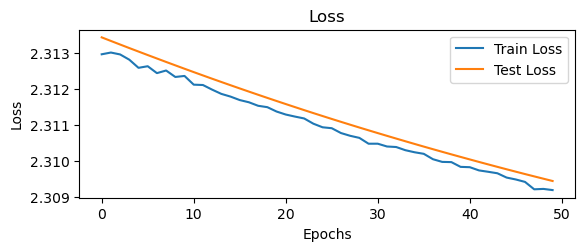

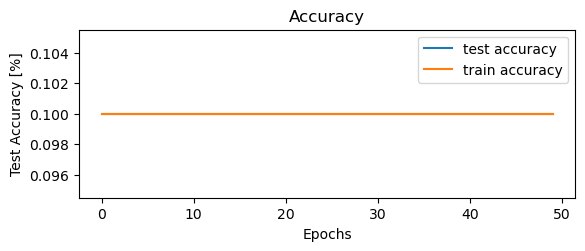

In [11]:
Sigmoid_train_loss = []
Sigmoid_test_loss = []

Sigmoid_train_accuracy = []
Sigmoid_test_accuracy = []

lr = 0.001

model_Sigmoid = Sigmoid(32 * 32 * 3, 10)
model_Sigmoid = model_Sigmoid.to('cuda')

##Model이 Sigmoid+SGD인 경우
sgd_optimizer = SGD(model_Sigmoid.parameters(), lr=lr)

train_and_test(model_Sigmoid, 
               Sigmoid_train_loss,
               Sigmoid_test_loss,
               Sigmoid_train_accuracy,
               Sigmoid_test_accuracy,
               sgd_optimizer)
plot(Sigmoid_train_loss,
     Sigmoid_test_loss, 
     Sigmoid_train_accuracy, 
     Sigmoid_test_accuracy)

epoch : 0 | loss : 2.295350
epoch : 1 | loss : 2.247143
epoch : 2 | loss : 2.181040
epoch : 3 | loss : 2.148998
epoch : 4 | loss : 2.134391
epoch : 5 | loss : 2.122508
epoch : 6 | loss : 2.113916
epoch : 7 | loss : 2.108109
epoch : 8 | loss : 2.102726
epoch : 9 | loss : 2.098772
epoch : 10 | loss : 2.093985
epoch : 11 | loss : 2.090921
epoch : 12 | loss : 2.087458
epoch : 13 | loss : 2.085963
epoch : 14 | loss : 2.082872
epoch : 15 | loss : 2.081011
epoch : 16 | loss : 2.078879
epoch : 17 | loss : 2.076282
epoch : 18 | loss : 2.073561
epoch : 19 | loss : 2.072121
epoch : 20 | loss : 2.069360
epoch : 21 | loss : 2.067606
epoch : 22 | loss : 2.065634
epoch : 23 | loss : 2.062737
epoch : 24 | loss : 2.060835
epoch : 25 | loss : 2.057444
epoch : 26 | loss : 2.055172
epoch : 27 | loss : 2.053279
epoch : 28 | loss : 2.050942
epoch : 29 | loss : 2.047129
epoch : 30 | loss : 2.044032
epoch : 31 | loss : 2.042117
epoch : 32 | loss : 2.041898
epoch : 33 | loss : 2.040716
epoch : 34 | loss : 2.03

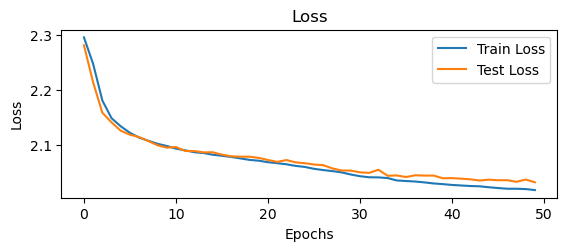

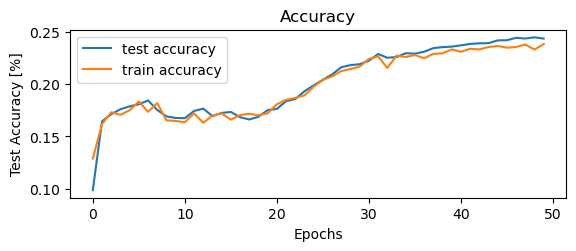

In [12]:
Sigmoid_train_loss = []
Sigmoid_test_loss = []

Sigmoid_train_accuracy = []
Sigmoid_test_accuracy = []

lr = 0.001

model_Sigmoid = Sigmoid(32 * 32 * 3, 10)
model_Sigmoid = model_Sigmoid.to('cuda')

##Model이 Sigmoid+adam인 경우
Adam_optimizer = Adam(model_Sigmoid.parameters(), lr=lr)

train_and_test(model_Sigmoid, 
               Sigmoid_train_loss,
               Sigmoid_test_loss,
               Sigmoid_train_accuracy,
               Sigmoid_test_accuracy,
               Adam_optimizer)
plot(Sigmoid_train_loss,
     Sigmoid_test_loss, 
     Sigmoid_train_accuracy, 
     Sigmoid_test_accuracy)

Sigmoid Model에서 또한 Adam이 SGD보다 우수한 성능을 보인다.

RELU, Sigmoid Model 둘 다 Adam이 우위

In [13]:
class LeakyRELU_dropout(nn.Module):
  def __init__(self, input_dim, n_dim):
    super(LeakyRELU_dropout, self).__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.dropout1 = nn.Dropout(0.5)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.dropout2 = nn.Dropout(0.5)
    self.layer3 = nn.Linear(n_dim, 10) #0~9의 확률이 나오기때문

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout1(x)
    x = self.act(self.layer2(x))
    x = self.dropout2(x)
    x = self.act(self.layer3(x))

    return x
      
class Sigmoid_dropout(nn.Module):
  def __init__(self, input_dim, n_dim):
    super(Sigmoid_dropout, self).__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.dropout1 = nn.Dropout(0.5)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.dropout2 = nn.Dropout(0.5)
    self.layer3 = nn.Linear(n_dim, 10) #0~9의 확률이 나오기때문

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout1(x)
    x = self.act(self.layer2(x))
    x = self.dropout2(x)
    x = self.act(self.layer3(x))

    return x

epoch : 0 | loss : 2.309543
epoch : 1 | loss : 2.306947
epoch : 2 | loss : 2.305895
epoch : 3 | loss : 2.304956
epoch : 4 | loss : 2.304130
epoch : 5 | loss : 2.303281
epoch : 6 | loss : 2.302395
epoch : 7 | loss : 2.301451
epoch : 8 | loss : 2.300440
epoch : 9 | loss : 2.299493
epoch : 10 | loss : 2.298620
epoch : 11 | loss : 2.297657
epoch : 12 | loss : 2.296814
epoch : 13 | loss : 2.295834
epoch : 14 | loss : 2.294973
epoch : 15 | loss : 2.294011
epoch : 16 | loss : 2.293146
epoch : 17 | loss : 2.292271
epoch : 18 | loss : 2.291467
epoch : 19 | loss : 2.290737
epoch : 20 | loss : 2.289994
epoch : 21 | loss : 2.289323
epoch : 22 | loss : 2.288675
epoch : 23 | loss : 2.287932
epoch : 24 | loss : 2.287247
epoch : 25 | loss : 2.286594
epoch : 26 | loss : 2.285933
epoch : 27 | loss : 2.285350
epoch : 28 | loss : 2.284565
epoch : 29 | loss : 2.283815
epoch : 30 | loss : 2.282850
epoch : 31 | loss : 2.281673
epoch : 32 | loss : 2.280158
epoch : 33 | loss : 2.278388
epoch : 34 | loss : 2.27

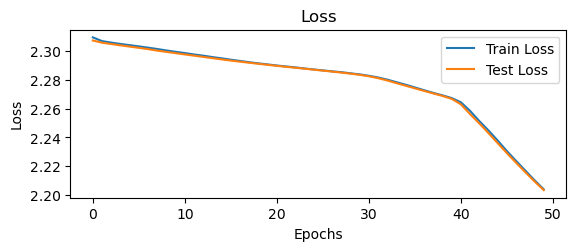

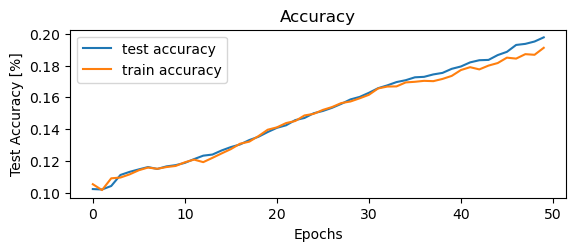

In [14]:
LeakyRELU_train_loss = []
LeakyRELU_test_loss = []

LeakyRELU_train_accuracy = []
LeakyRELU_test_accuracy = []

lr = 0.001

model_LeakyRELU = LeakyRELU_dropout(32 * 32 * 3, 10)
model_LeakyRELU = model_LeakyRELU.to('cuda')

##Model이 Leaky RELU+SGD+dropout인 경우
sgd_optimizer = SGD(model_LeakyRELU.parameters(), lr=lr)

train_and_test(model_LeakyRELU, 
               LeakyRELU_train_loss,
               LeakyRELU_test_loss,
               LeakyRELU_train_accuracy,
               LeakyRELU_test_accuracy,
               sgd_optimizer)
plot(LeakyRELU_train_loss,
     LeakyRELU_test_loss, 
     LeakyRELU_train_accuracy, 
     LeakyRELU_test_accuracy)

epoch : 0 | loss : 2.277930
epoch : 1 | loss : 2.129669
epoch : 2 | loss : 1.977633
epoch : 3 | loss : 1.909054
epoch : 4 | loss : 1.883682
epoch : 5 | loss : 1.867858
epoch : 6 | loss : 1.858946
epoch : 7 | loss : 1.851079
epoch : 8 | loss : 1.835255
epoch : 9 | loss : 1.815541
epoch : 10 | loss : 1.802149
epoch : 11 | loss : 1.789644
epoch : 12 | loss : 1.780718
epoch : 13 | loss : 1.774792
epoch : 14 | loss : 1.774829
epoch : 15 | loss : 1.761998
epoch : 16 | loss : 1.758766
epoch : 17 | loss : 1.752044
epoch : 18 | loss : 1.747452
epoch : 19 | loss : 1.745218
epoch : 20 | loss : 1.736612
epoch : 21 | loss : 1.733311
epoch : 22 | loss : 1.728357
epoch : 23 | loss : 1.723683
epoch : 24 | loss : 1.717176
epoch : 25 | loss : 1.713768
epoch : 26 | loss : 1.709929
epoch : 27 | loss : 1.706499
epoch : 28 | loss : 1.701189
epoch : 29 | loss : 1.696014
epoch : 30 | loss : 1.698466
epoch : 31 | loss : 1.689643
epoch : 32 | loss : 1.685903
epoch : 33 | loss : 1.686901
epoch : 34 | loss : 1.68

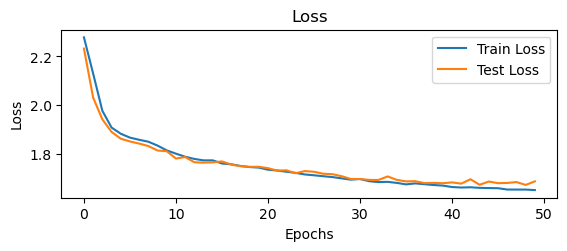

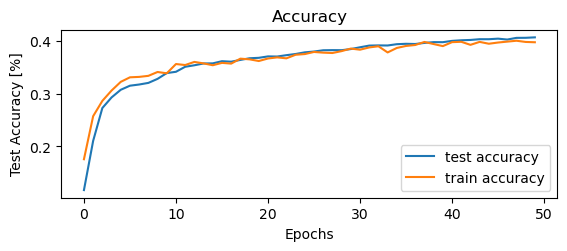

In [15]:
LeakyRELU_train_loss = []
LeakyRELU_test_loss = []

LeakyRELU_train_accuracy = []
LeakyRELU_test_accuracy = []

lr = 0.001

model_LeakyRELU = LeakyRELU_dropout(32 * 32 * 3, 10)
model_LeakyRELU = model_LeakyRELU.to('cuda')

##Model이 Leaky RELU+adam+dropout인 경우
adam_optimizer = Adam(model_LeakyRELU.parameters(), lr=lr)

train_and_test(model_LeakyRELU, 
               LeakyRELU_train_loss,
               LeakyRELU_test_loss,
               LeakyRELU_train_accuracy,
               LeakyRELU_test_accuracy,
               adam_optimizer)
plot(LeakyRELU_train_loss,
     LeakyRELU_test_loss, 
     LeakyRELU_train_accuracy, 
     LeakyRELU_test_accuracy)

epoch : 0 | loss : 2.257416
epoch : 1 | loss : 2.004867
epoch : 2 | loss : 1.863510
epoch : 3 | loss : 1.824283
epoch : 4 | loss : 1.803221
epoch : 5 | loss : 1.782800
epoch : 6 | loss : 1.771911
epoch : 7 | loss : 1.760844
epoch : 8 | loss : 1.755391
epoch : 9 | loss : 1.745936
epoch : 10 | loss : 1.738299
epoch : 11 | loss : 1.730775
epoch : 12 | loss : 1.723366
epoch : 13 | loss : 1.715324
epoch : 14 | loss : 1.711447
epoch : 15 | loss : 1.707597
epoch : 16 | loss : 1.702798
epoch : 17 | loss : 1.696597
epoch : 18 | loss : 1.690241
epoch : 19 | loss : 1.683776
epoch : 20 | loss : 1.685787
epoch : 21 | loss : 1.683963
epoch : 22 | loss : 1.678573
epoch : 23 | loss : 1.676446
epoch : 24 | loss : 1.670001
epoch : 25 | loss : 1.666727
epoch : 26 | loss : 1.660351
epoch : 27 | loss : 1.656604
epoch : 28 | loss : 1.654936
epoch : 29 | loss : 1.649341
epoch : 30 | loss : 1.653025
epoch : 31 | loss : 1.646721
epoch : 32 | loss : 1.645048
epoch : 33 | loss : 1.642625
epoch : 34 | loss : 1.63

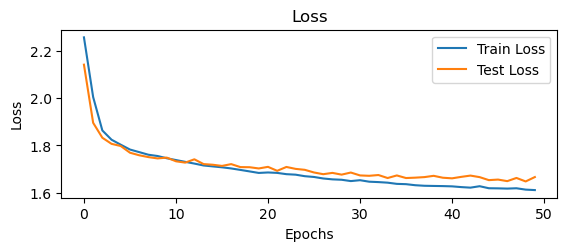

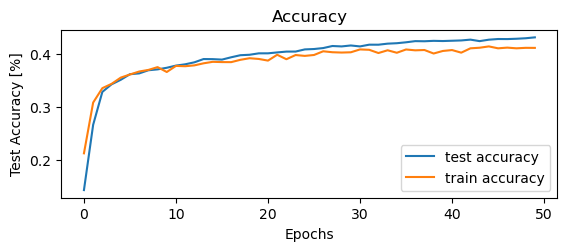

epoch : 0 | loss : 2.216633
epoch : 1 | loss : 2.069352
epoch : 2 | loss : 2.017889
epoch : 3 | loss : 1.937530
epoch : 4 | loss : 1.886393
epoch : 5 | loss : 1.868915
epoch : 6 | loss : 1.853362
epoch : 7 | loss : 1.842873
epoch : 8 | loss : 1.836177
epoch : 9 | loss : 1.826285
epoch : 10 | loss : 1.818838
epoch : 11 | loss : 1.811891
epoch : 12 | loss : 1.806131
epoch : 13 | loss : 1.799340
epoch : 14 | loss : 1.792166
epoch : 15 | loss : 1.785305
epoch : 16 | loss : 1.778927
epoch : 17 | loss : 1.774739
epoch : 18 | loss : 1.766264
epoch : 19 | loss : 1.765512
epoch : 20 | loss : 1.758686
epoch : 21 | loss : 1.755996
epoch : 22 | loss : 1.752873
epoch : 23 | loss : 1.749597
epoch : 24 | loss : 1.743502
epoch : 25 | loss : 1.743604
epoch : 26 | loss : 1.739276
epoch : 27 | loss : 1.733094
epoch : 28 | loss : 1.732490
epoch : 29 | loss : 1.727345
epoch : 30 | loss : 1.726442
epoch : 31 | loss : 1.720417
epoch : 32 | loss : 1.723274
epoch : 33 | loss : 1.719541
epoch : 34 | loss : 1.71

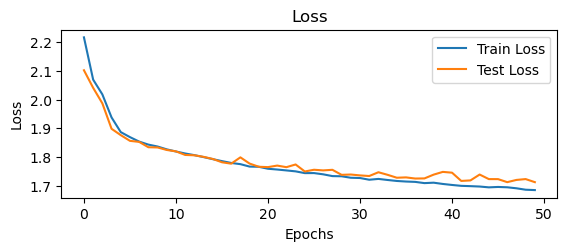

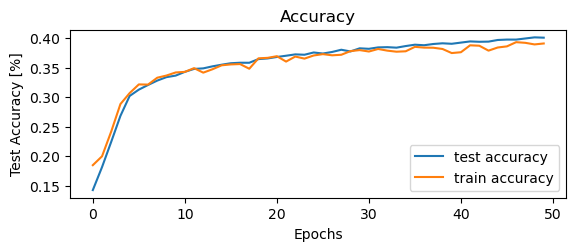

epoch : 0 | loss : 2.245496
epoch : 1 | loss : 2.029368
epoch : 2 | loss : 1.890651
epoch : 3 | loss : 1.854455
epoch : 4 | loss : 1.839645
epoch : 5 | loss : 1.822676
epoch : 6 | loss : 1.801534
epoch : 7 | loss : 1.776297
epoch : 8 | loss : 1.749373
epoch : 9 | loss : 1.740044
epoch : 10 | loss : 1.728075
epoch : 11 | loss : 1.715939
epoch : 12 | loss : 1.707450
epoch : 13 | loss : 1.701571
epoch : 14 | loss : 1.694497
epoch : 15 | loss : 1.689603
epoch : 16 | loss : 1.684998
epoch : 17 | loss : 1.678727
epoch : 18 | loss : 1.675818
epoch : 19 | loss : 1.675265
epoch : 20 | loss : 1.671498
epoch : 21 | loss : 1.664438
epoch : 22 | loss : 1.659424
epoch : 23 | loss : 1.659243
epoch : 24 | loss : 1.655657
epoch : 25 | loss : 1.658203
epoch : 26 | loss : 1.648172
epoch : 27 | loss : 1.646908
epoch : 28 | loss : 1.644476
epoch : 29 | loss : 1.641218
epoch : 30 | loss : 1.640254
epoch : 31 | loss : 1.636483
epoch : 32 | loss : 1.631287
epoch : 33 | loss : 1.625935
epoch : 34 | loss : 1.62

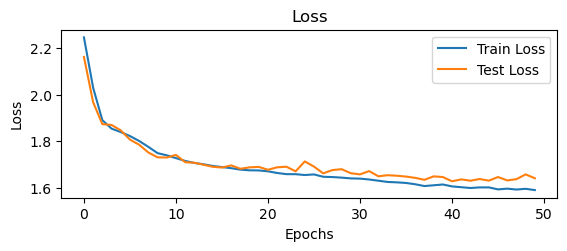

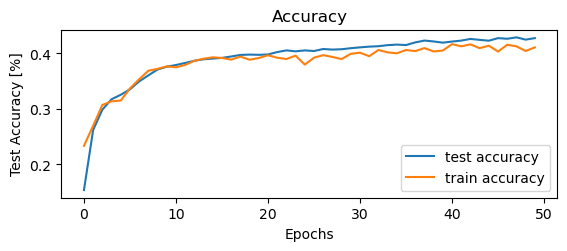

epoch : 0 | loss : 2.303032
epoch : 1 | loss : 2.269812
epoch : 2 | loss : 2.172903
epoch : 3 | loss : 1.976293
epoch : 4 | loss : 1.905287
epoch : 5 | loss : 1.875818
epoch : 6 | loss : 1.859557
epoch : 7 | loss : 1.840606
epoch : 8 | loss : 1.819848
epoch : 9 | loss : 1.794739
epoch : 10 | loss : 1.784144
epoch : 11 | loss : 1.775669
epoch : 12 | loss : 1.768870
epoch : 13 | loss : 1.755843
epoch : 14 | loss : 1.747230
epoch : 15 | loss : 1.741523
epoch : 16 | loss : 1.739397
epoch : 17 | loss : 1.731952
epoch : 18 | loss : 1.729032
epoch : 19 | loss : 1.723413
epoch : 20 | loss : 1.720153
epoch : 21 | loss : 1.720880
epoch : 22 | loss : 1.708883
epoch : 23 | loss : 1.710594
epoch : 24 | loss : 1.709746
epoch : 25 | loss : 1.706543
epoch : 26 | loss : 1.698750
epoch : 27 | loss : 1.699888
epoch : 28 | loss : 1.695339
epoch : 29 | loss : 1.693435
epoch : 30 | loss : 1.692223
epoch : 31 | loss : 1.688314
epoch : 32 | loss : 1.686158
epoch : 33 | loss : 1.684475
epoch : 34 | loss : 1.68

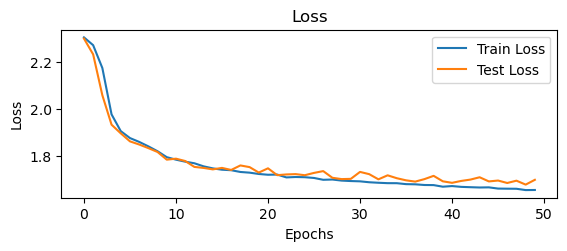

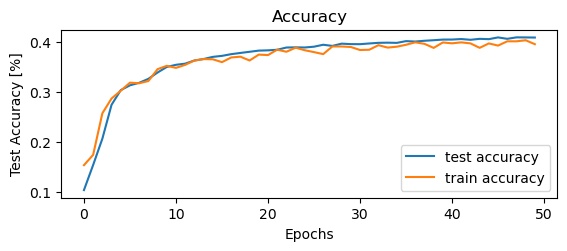

epoch : 0 | loss : 2.298244
epoch : 1 | loss : 2.068910
epoch : 2 | loss : 1.892522
epoch : 3 | loss : 1.850610
epoch : 4 | loss : 1.831567
epoch : 5 | loss : 1.805575
epoch : 6 | loss : 1.782609
epoch : 7 | loss : 1.756853
epoch : 8 | loss : 1.745957
epoch : 9 | loss : 1.732652
epoch : 10 | loss : 1.727718
epoch : 11 | loss : 1.716550
epoch : 12 | loss : 1.712185
epoch : 13 | loss : 1.707788
epoch : 14 | loss : 1.695333
epoch : 15 | loss : 1.691560
epoch : 16 | loss : 1.682446
epoch : 17 | loss : 1.678281
epoch : 18 | loss : 1.674112
epoch : 19 | loss : 1.671789
epoch : 20 | loss : 1.667312
epoch : 21 | loss : 1.664382
epoch : 22 | loss : 1.659791
epoch : 23 | loss : 1.655027
epoch : 24 | loss : 1.654042
epoch : 25 | loss : 1.649374
epoch : 26 | loss : 1.651209
epoch : 27 | loss : 1.643010
epoch : 28 | loss : 1.644432
epoch : 29 | loss : 1.639982
epoch : 30 | loss : 1.637841
epoch : 31 | loss : 1.635290
epoch : 32 | loss : 1.634683
epoch : 33 | loss : 1.628502
epoch : 34 | loss : 1.62

KeyboardInterrupt: 

In [12]:
from torch.optim import SGD
from torch.optim import Adam
import torch.nn.functional as f
import numpy as np

class LeakyRELU_dropout_sweep(nn.Module):
  def __init__(self, input_dim, n_dim, dropout):
    super(LeakyRELU_dropout_sweep, self).__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.dropout1 = nn.Dropout(dropout)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.dropout2 = nn.Dropout(dropout)
    self.layer3 = nn.Linear(n_dim, 10) #0~9의 확률이 나오기때문

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout1(x)
    x = self.act(self.layer2(x))
    x = self.dropout2(x)
    x = self.act(self.layer3(x))

    return x


LeakyRELU_train_loss = []
LeakyRELU_test_loss = []

LeakyRELU_train_accuracy = []
LeakyRELU_test_accuracy = []

lr = 0.001

for dropout in np.arange(0.1, 1, 0.1):
    model_LeakyRELU = LeakyRELU_dropout_sweep(32 * 32 * 3, 10, dropout)
    model_LeakyRELU = model_LeakyRELU.to('cuda')

    adam_optimizer = Adam(model_LeakyRELU.parameters(), lr=lr)

    train_and_test(model_LeakyRELU, 
               LeakyRELU_train_loss,
               LeakyRELU_test_loss,
               LeakyRELU_train_accuracy,
               LeakyRELU_test_accuracy,
               adam_optimizer)
    plot(LeakyRELU_train_loss,
     LeakyRELU_test_loss, 
     LeakyRELU_train_accuracy, 
     LeakyRELU_test_accuracy)
    
    LeakyRELU_train_loss = []
    LeakyRELU_test_loss = []

    LeakyRELU_train_accuracy = []
    LeakyRELU_test_accuracy = []

drop 수치 별 그래프를 확인 해봤지만 Accuracy 관점에서 개선되는 점은 없는듯함.